# San Francisco Crime Rate
https://www.kaggle.com/c/sf-crime/overview

## 1. Problem definition
From 1934 to 1963, San Francisco was infamous for housing some of the world's most notorious criminals on the inescapable island of Alcatraz.
Today, the city is known more for its tech scene than its criminal past. But, with rising wealth inequality, housing shortages, and a proliferation of expensive digital toys riding BART to work, there is no scarcity of crime in the city by the bay.
From Sunset to SOMA, and Marina to Excelsior, this competition's dataset provides nearly 12 years of crime reports from across all of San Francisco's neighborhoods.

**Objective:** Given time and location, you must predict the category of crime that occurred.


## 2. Data
* **Category = Target** - category of the crime incident **(only in train.csv)**.
* Descript - detailed description of the crime incident **(only in train.csv)**
* Resolution - how the crime incident was resolved **(only in train.csv)**
* DayOfWeek - the day of the week
* Dates - timestamp of the crime incident
* PdDistrict - name of the Police Department District
* Address - the approximate street address of the crime incident 
* X - Longitude
* Y - Latitude

1. train.csv - The training set. Each row has the **ACTION (ground truth)**, **RESOURCE**, and **information** about the employee's role at the time of approval

2. test.csv - The test set for which predictions should be made.  Each row asks whether an employee having the listed characteristics should have access to the **listed resource**.

## 3. Evaluation
Submissions are evaluated using the multi-class logarithmic loss. Each incident has been labeled with one true class. For each incident, you must submit a set of predicted probabilities .

## 4. Submission
You must submit a csv file with the incident id, all candidate class names, and a probability for each class. The order of the rows does not matter. The file must have a header and should look like the following:

`Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,SEX OFFENSES FORCIBLE,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0.9,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...`

## 5. Feature importance
Determine which features are important and repeat the process

In [1]:
# basic
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

# modelling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# xgboost
from xgboost import XGBClassifier

# lightgbm
import lightgbm as lgb

# metrics"
from sklearn.metrics import plot_roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Import data

In [2]:
train_df = pd.read_csv('train.csv', parse_dates = ['Dates'])

In [3]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
len(train_df)

878049

In [5]:
train_df.isna().sum()

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

In [31]:
len(train_df['Category'].unique())

39

**Given that the test data does not include the Descript or the Resolution columns, we will initially remove them to focus on the more important**

In [110]:
df = train_df.copy()
df.drop(columns=['Descript', 'Resolution'], axis=1, inplace=True)

In [112]:
df.dtypes

Dates         datetime64[ns]
Category              object
DayOfWeek             object
PdDistrict            object
Address               object
X                    float64
Y                    float64
dtype: object

# Augment data

**Break date into day, month, year, hour**

In [113]:
df['Year'] = df['Dates'].dt.year
df['Month'] = df['Dates'].dt.month
df['Day'] = df['Dates'].dt.day
df['Hour'] = df['Dates'].dt.hour
df['Dayofweek'] = df['Dates'].dt.dayofweek

In [114]:
# subtract 2000 from the year to keep data in the same range
df['Year'] = df['Year'] - 2000

In [115]:
df.drop('Dates', axis=1, inplace=True)
df.drop('DayOfWeek', axis=1, inplace=True)

### Exact address is irrelevant. Replace it by checking if it is a street or an avenue

In [117]:
def check_st_at(str_list):
    for word in str_list.split():
        if word == 'AV':
            return 'AV'
    return 'ST'

In [118]:
df['Roadtype'] = df.apply(lambda row: check_st_at(row.Address), axis=1)

In [119]:
# we can now drop Address
df.drop('Address', axis=1, inplace=True)

### Normalize coordinates

In [121]:
scaler_X = preprocessing.MinMaxScaler()
scaler_Y = preprocessing.MinMaxScaler()

X_def, Y_def = df['X'].values, df['Y'].values #returns a numpy array
X_scaled = scaler_X.fit_transform(X_def.reshape([-1,1]))
Y_scaled = scaler_Y.fit_transform(Y_def.reshape([-1,1]))

df['X'] = X_scaled
df['Y'] = Y_scaled

In [129]:
### Save pre-processed df to csv
df.to_csv('preprocessed_data.csv', index=False)

# EDA

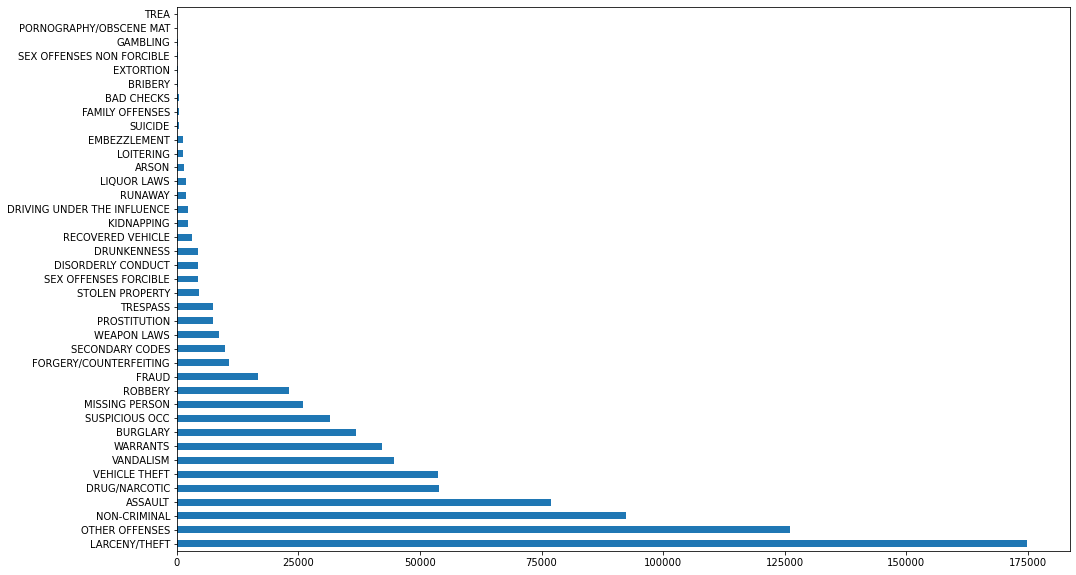

In [153]:
df['Category'].value_counts().plot(kind='barh', figsize=(16,10));

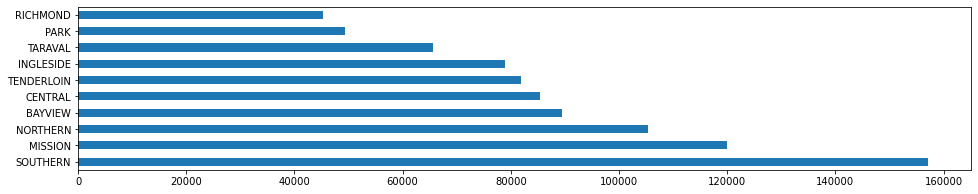

In [159]:
df['PdDistrict'].value_counts().plot(kind='barh', figsize=(16,3));

[Text(0.5, 0, 'X'), Text(0, 0.5, 'Y')]

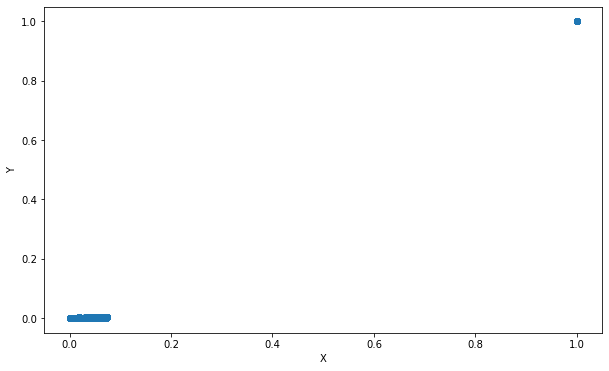

In [163]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(df['X'], df['Y']);
ax.set(xlabel='X',
       ylabel='Y');

In [166]:
# lets look for outliers
to_drop = df[(df['X'] > 0.9)|(df['Y'] > 0.9)].index
to_drop

Int64Index([660485, 660711, 660712, 661106, 666430, 667042, 669946, 671709,
            673078, 673114, 673115, 673510, 674043, 675070, 675073, 675288,
            675540, 677036, 677260, 677268, 677828, 678326, 678539, 678540,
            679643, 682780, 683862, 684406, 685719, 685720, 686997, 687519,
            687527, 688950, 692258, 712309, 719993, 727080, 754828, 756059,
            759292, 759397, 767318, 767501, 767502, 772415, 772431, 773159,
            783919, 788574, 788575, 789255, 798834, 823378, 833362, 833921,
            839585, 842259, 842261, 842434, 842435, 842828, 844995, 845842,
            852880, 857248, 871198],
           dtype='int64')

In [167]:
# drop outliers since they are only 67 and rescale
df.drop(to_drop, inplace=True)

In [168]:
scaler_X = preprocessing.MinMaxScaler()
scaler_Y = preprocessing.MinMaxScaler()

X_def, Y_def = df['X'].values, df['Y'].values #returns a numpy array
X_scaled = scaler_X.fit_transform(X_def.reshape([-1,1]))
Y_scaled = scaler_Y.fit_transform(Y_def.reshape([-1,1]))

df['X'] = X_scaled
df['Y'] = Y_scaled

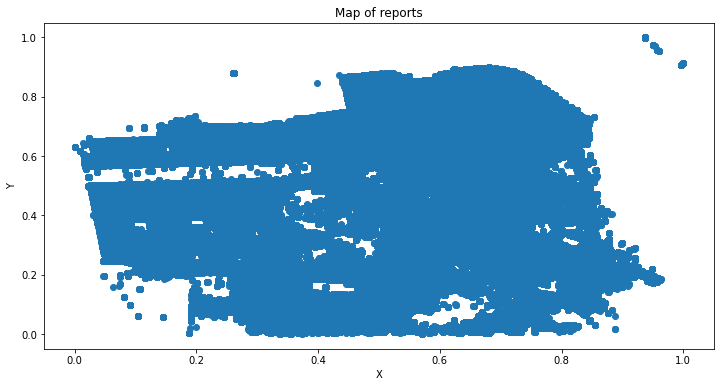

In [172]:
fig, ax = plt.subplots(figsize=(12,6))

ax.scatter(df['X'], df['Y']);
ax.set(xlabel='X',
       ylabel='Y',
       title='Map of reports');

In [173]:
### Save pre-processed df to csv
df.to_csv('preprocessed_data_dropped.csv', index=False)

## Distribution of reports over the year, months, days, hours

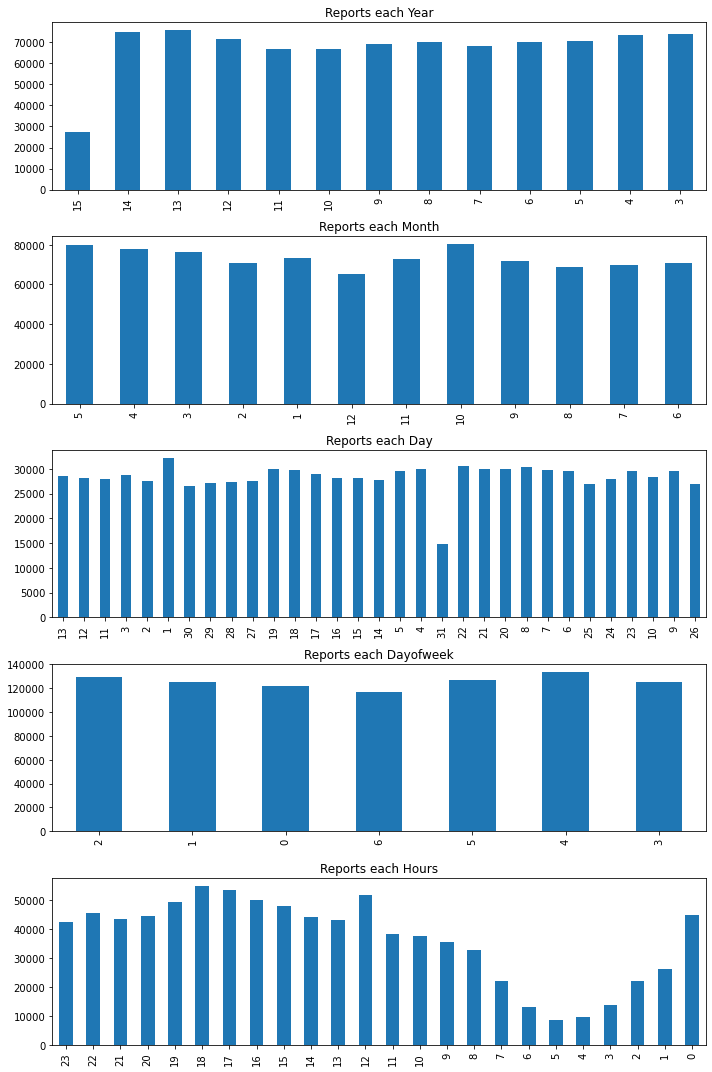

In [195]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=5, figsize=(10,15))

df['Year'].value_counts(sort=False).plot(kind='bar', ax=ax0)
df['Month'].value_counts(sort=False).plot(kind='bar', ax=ax1)
df['Day'].value_counts(sort=False).plot(kind='bar', ax=ax2)
df['Dayofweek'].value_counts(sort=False).plot(kind='bar', ax=ax3)
df['Hour'].value_counts(sort=False).plot(kind='bar', ax=ax4)

ax0.set(title='Reports each Year')
ax1.set(title='Reports each Month')
ax2.set(title='Reports each Day')
ax3.set(title='Reports each Dayofweek')
ax4.set(title='Reports each Hours')

plt.tight_layout()

## Distribution of PDs

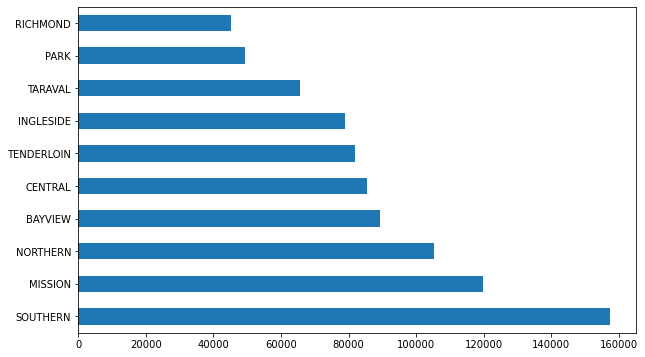

In [186]:
df['PdDistrict'].value_counts().plot(kind='barh', figsize=(10,6));

## Distribution over Roadtype

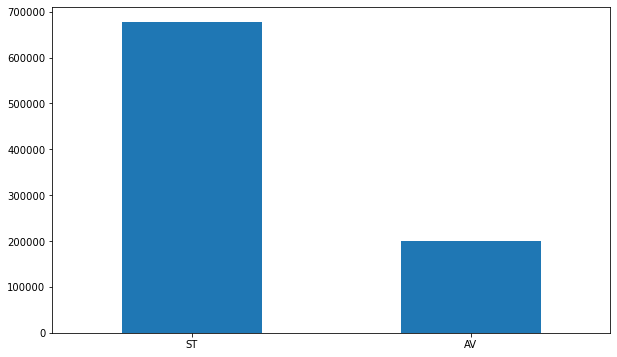

In [191]:
df['Roadtype'].value_counts().plot(kind='bar', figsize=(10,6));
plt.xticks(rotation='horizontal');

## Check the correlation between Minutes and Felony
For each minute, extract the top 3 most likely charges

In [94]:
sum_each_minute = df.groupby('Minute')['X'].count()

In [95]:
s = df.groupby(["Minute", 'Category'], as_index=False)['X'].count()

In [96]:
s = s.groupby(['Minute']).apply(lambda x: x.sort_values(['X'],ascending = False)).reset_index(drop = True)

In [105]:
top3_each_minute = s.groupby(['Minute']).head(3).rename(columns={'X':'count'}).set_index('Minute')

In [106]:
top3_each_minute

,Category,count
Minute,,
0,LARCENY/THEFT,76622
0,NON-CRIMINAL,31432
0,VEHICLE THEFT,30380
1,LARCENY/THEFT,4726
1,OTHER OFFENSES,3681
...,...,...
58,DRUG/NARCOTIC,664
58,NON-CRIMINAL,495
59,OTHER OFFENSES,900


In [113]:
sum_each_minute

Minute
0     268930
1      25859
2       4403
3       4624
4       4701
5      15764
6       4654
7       4658
8       5026
9       4422
10     22761
11      4550
12      5019
13      4629
14      4829
15     37900
16      4408
17      4787
18      5242
19      4529
20     26025
21      4284
22      4996
23      4903
24      4764
25     16176
26      4401
27      4726
28      4875
29      4392
30    125165
31      4120
32      4493
33      4737
34      4516
35     15549
36      4463
37      4807
38      4946
39      4522
40     24668
41      4383
42      4811
43      4599
44      4704
45     40227
46      4377
47      4620
48      5059
49      4341
50     25495
51      4308
52      4570
53      4748
54      4618
55     15406
56      4437
57      4637
58      4850
59      4569
Name: X, dtype: int64

**Based on evidence, the minutes in highly probable to be either 0, 15, 30, or 45. As such, we will discard minute**

# Create a data preprocessing function

In [4]:
def check_st_at(str_list):
    for word in str_list.split():
        if word == 'AV':
            return 'AV'
    return 'ST'

In [5]:
def preprocess_df(df_in, is_train = True):
    
    df = df_in.copy()
    
    if is_train: 
        df.drop(columns=['Descript', 'Resolution'], axis=1, inplace=True)
    df['Year'] = df['Dates'].dt.year
    df['Month'] = df['Dates'].dt.month
    df['Day'] = df['Dates'].dt.day
    df['Hour'] = df['Dates'].dt.hour
    df['Minute'] = df['Dates'].dt.minute
    df['Dayofweek'] = df['Dates'].dt.dayofweek
    
    df.drop('Dates', axis=1, inplace=True)
    df.drop('DayOfWeek', axis=1, inplace=True)
    
    # subtract 2000 from the year to keep data in the same range
    df['Year'] = df['Year'] - 2000
    
    df['Roadtype'] = df.apply(lambda row: check_st_at(row.Address), axis=1)
    df['Block'] = df['Address'].str.contains('block', case=False).apply(lambda x: 1 if x == True else 0)
    # we can now drop Address
    df.drop('Address', axis=1, inplace=True)
    
    # Drop outliers
    to_drop = df[(df['X'] == -120.5)|(df['Y'] == 90)].index
    if is_train:
        df.drop(to_drop, inplace=True)
    
    scaler_X = preprocessing.MinMaxScaler()
    scaler_Y = preprocessing.MinMaxScaler()
    scaler_XY = preprocessing.MinMaxScaler()
    scaler_sum = preprocessing.MinMaxScaler()
    scaler_diff = preprocessing.MinMaxScaler()
    scaler_prod = preprocessing.MinMaxScaler()

    X_def, Y_def = df['X'].values, df['Y'].values #returns a numpy array
    XY_sq = X_def**2 + Y_def**2
    XYsum = X_def + Y_def
    XYdiff = X_def - Y_def
    XYprod = np.multiply(X_def, Y_def)
    
    X_scaled = scaler_X.fit_transform(X_def.reshape([-1,1]))
    Y_scaled = scaler_Y.fit_transform(Y_def.reshape([-1,1]))
    XY_sq_scaled = scaler_XY.fit_transform(XY_sq.reshape([-1,1]))
    XY_sum_scaled = scaler_sum.fit_transform(XYsum.reshape([-1,1]))
    XY_diff_scaled = scaler_diff.fit_transform(XYdiff.reshape([-1,1]))
    XY_prod_scaled = scaler_prod.fit_transform(XYprod.reshape([-1,1]))

    df['X'] = X_scaled
    df['Y'] = Y_scaled
    df['XYsq'] = XY_sq_scaled
    df['XYsum'] = XY_sum_scaled
    df['XYdiff'] = XY_diff_scaled
    df['XYprod'] = XY_prod_scaled
    
    #encode categorical columns
    if is_train:
        df['Category'] = df['Category'].astype('category')
    df['PdDistrict'] = df['PdDistrict'].astype('category')b
    df['Roadtype'] = df['Roadtype'].astype('category')
    
    df_cat = df.copy()
    
    if is_train:
        df_cat['Category'] = df_cat['Category'].cat.codes
    df_cat['PdDistrict'] = df_cat['PdDistrict'].cat.codes
    df_cat['Roadtype'] = df_cat['Roadtype'].cat.codes
    
    return df_cat, df

# Model

## Load and prepare data

In [6]:
train_df = pd.read_csv('train.csv', parse_dates = ['Dates'], low_memory=False)

df_cat2, df2 = preprocess_df(train_df)

In [7]:
X = df_cat2.drop(columns= ['Category'])
y = df_cat2['Category']

## KNN

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [42]:
knn = KNeighborsClassifier(n_neighbors=100)

In [43]:
%%time
knn.fit(X_train, y_train)

Wall time: 34.8 s


KNeighborsClassifier(n_neighbors=100)

In [44]:
y_probs_train = knn.predict_proba(X_train)
y_probs_val = knn.predict_proba(X_test)

print(log_loss(y_train, y_probs_train))
print(log_loss(y_test, y_probs_val))

2.356131881691766
3.933750913077195


### KNN - Grid Search

In [168]:
grid = {'n_neighbors':[5, 10, 15, 30]}

In [ ]:
clf = GridSearchCV(estimator=knn, 
                       scoring='neg_log_loss',
                       param_grid=grid, 
                       cv = 3,
                       verbose=3)
search = clf.fit(X, y)


[CV 1/3] END ...................n_neighbors=5;, score=-22.554 total time= 1.2min

[CV 2/3] END ...................n_neighbors=5;, score=-24.827 total time= 1.3min

## Logistic Regression

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [93]:
logreg = LogisticRegression(n_jobs=-1, C=1000,
                           solver='saga', penalty='elasticnet',
                           l1_ratio=0.5)

In [95]:
logreg.fit(X_train, y_train)

D:\MachineLearning\MyProjects\SanFranciscoCrimes\env\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(C=1000, l1_ratio=0.5, n_jobs=-1, penalty='elasticnet',
                   solver='saga')

In [96]:
y_probs_train = logreg.predict_proba(X_train)
y_probs_val = logreg.predict_proba(X_test)

print(log_loss(y_train, y_probs_train))
print(log_loss(y_test, y_probs_val))

2.5391372261544785
2.537733936411284


### Logistic Regression - Random Search

In [37]:
from scipy.stats import uniform

In [87]:
logisticreg = LogisticRegression(n_jobs=-1)

In [88]:
distributions = {'C': [10, 100, 1000, 1500]}

In [ ]:
clf = RandomizedSearchCV(estimator=logisticreg, 
                       scoring='neg_log_loss',
                       param_distributions=distributions, 
                       cv = 3, n_iter=10,
                       verbose=3)
search = clf.fit(X, y)

**stopped early**

[CV 1/3] END ...............C=3.02376474657701;, score=-2.726 total time= 2.1min

[CV 2/3] END ...............C=3.02376474657701;, score=-2.573 total time= 1.9min

[CV 3/3] END ...............C=3.02376474657701;, score=-2.744 total time= 2.2min

[CV 1/3] END .............C=2.0708633834696384;, score=-2.724 total time= 2.1min

[CV 2/3] END .............C=2.0708633834696384;, score=-2.574 total time= 2.2min

[CV 3/3] END .............C=2.0708633834696384;, score=-2.745 total time= 2.1min

[CV 1/3] END ..............C=3.327777222432624;, score=-2.725 total time= 2.2min

[CV 2/3] END ..............C=3.327777222432624;, score=-2.573 total time= 2.0min

[CV 3/3] END ..............C=3.327777222432624;, score=-2.744 total time= 1.9min

[CV 1/3] END ..............C=0.921754008177837;, score=-2.721 total time= 1.9min

[CV 2/3] END ..............C=0.921754008177837;, score=-2.573 total time= 1.9min

[CV 3/3] END ..............C=0.921754008177837;, score=-2.746 total time= 2.0min


### Logistic Regression with fewer features

In [122]:
X_s, y_s = X.drop(columns=['PdDistrict', 'Roadtype', 'Block', 'Minute']), y

In [123]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size = 0.3)

In [124]:
logreg_s = LogisticRegression(n_jobs=-1, C=1000,
                           solver='saga', penalty='elasticnet',
                           l1_ratio=0.5)

In [125]:
logreg_s.fit(X_train_s, y_train_s)

D:\MachineLearning\MyProjects\SanFranciscoCrimes\env\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(C=1000, l1_ratio=0.5, n_jobs=-1, penalty='elasticnet',
                   solver='saga')

In [126]:
y_probs_train = logreg_s.predict_proba(X_train_s)
y_probs_test = logreg_s.predict_proba(X_test_s)

In [127]:
print(log_loss(y_train_s, y_probs_train))
print(log_loss(y_test_s, y_probs_test))

2.632230655682441
2.6292167408274456


## Random Forest

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [9]:
rfc = RandomForestClassifier(n_jobs=-1, min_samples_split=50, min_samples_leaf=20,
                            n_estimators = 80)

In [23]:
rfc.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=20, min_samples_split=50,
                       n_estimators=80, n_jobs=-1)

In [24]:
y_probs_train = rfc.predict_proba(X_train)
y_probs_val = rfc.predict_proba(X_test)

print(log_loss(y_train, y_probs_train))
print(log_loss(y_test, y_probs_val))

1.9195065945209078
2.300256524634753


In [16]:
cv_res = cross_val_score(rfc, X, y, scoring='neg_log_loss',
               cv = 3)
print(cv_res)

[-3.42904581 -2.54988311 -5.50494495]


### Random Forest - Random Search

In [164]:
distributions = {'n_estimators':[60, 100, 150],
                'max_features':[10, 15],
                'max_depth':[10, 20, 40],
                'min_samples_split':[50, 100],
                'min_samples_leaf':[20, 30]}

In [ ]:
clf = RandomizedSearchCV(estimator=rfc, 
                       scoring='neg_log_loss',
                       param_distributions=distributions, 
                       cv = 3, n_iter=5,
                       verbose=3)
search = clf.fit(X, y)

[CV 1/3] END max_depth=40, max_features=15, min_samples_leaf=20, min_samples_split=50, n_estimators=100;, score=-19.812 total time= 3.4min

[CV 2/3] END max_depth=40, max_features=15, min_samples_leaf=20, min_samples_split=50, n_estimators=100;, score=-9.678 total time= 3.1min

[CV 3/3] END max_depth=40, max_features=15, min_samples_leaf=20, min_samples_split=50, n_estimators=100;, score=nan total time= 3.5min

[CV 1/3] END max_depth=20, max_features=15, min_samples_leaf=30, min_samples_split=100, n_estimators=150;, score=-18.414 total time= 5.3min

[CV 2/3] END max_depth=20, max_features=15, min_samples_leaf=30, min_samples_split=100, n_estimators=150;, score=-7.833 total time= 4.6min

In [15]:
y_probs_train = rfc.predict_proba(X_train)
y_probs_val = rfc.predict_proba(X_val)

In [ ]:
print(log_loss(y_train, y_probs_train))
print(log_loss(y_val, y_probs_val))

### Try using RF without the unimportant features

In [56]:
rfc_s = RandomForestClassifier(n_jobs=-1, 
                             min_samples_split=200, 
                             min_samples_leaf=120,
                            max_depth = 25,
                            n_estimators = 60)

In [46]:
X_s, y_s = X.drop(columns=['PdDistrict', 'Roadtype', 'Block', 'Minute']), y

In [47]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size = 0.3)

In [48]:
X_train_s.head()

,X,Y,Year,Month,Day,Hour,Dayofweek,XYsq,XYsum,XYdiff,XYprod
440115,0.631926,0.510017,9,3,5,1,3,0.381563,0.562336,0.535081,0.466307
504740,0.835993,0.257973,8,4,3,9,3,0.135474,0.571464,0.826688,0.765490
494437,0.490378,0.525553,8,5,28,10,2,0.517591,0.478106,0.421669,0.400794
528954,0.421642,0.702877,7,11,26,18,0,0.620662,0.520231,0.271888,0.217536
670425,0.727389,0.804120,5,11,5,21,5,0.356230,0.768092,0.441665,0.238904


In [57]:
rfc_s.fit(X_train_s, y_train_s)

RandomForestClassifier(max_depth=25, min_samples_leaf=120,
                       min_samples_split=200, n_estimators=60, n_jobs=-1)

In [58]:
y_probs_train = rfc_s.predict_proba(X_train_s)
y_probs_test = rfc_s.predict_proba(X_test_s)

In [59]:
print(log_loss(y_train_s, y_probs_train))
print(log_loss(y_test_s, y_probs_test))

2.284608626343765
2.39686856620676


### Random Search with few features

In [74]:
distributions = {'n_estimators':[40, 60, 80],
                'max_features':[2, 3, 4],
                'max_depth':[20, 30, 40],
                'min_samples_split':[100, 120, 170],
                'min_samples_leaf':[60, 80]}

In [76]:
clf = RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=-1), 
                       scoring='neg_log_loss',
                       param_distributions=distributions, 
                       cv = 3, n_iter=10,
                       verbose=3)
search = clf.fit(X_s, y_s)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END max_depth=40, max_features=2, min_samples_leaf=80, min_samples_split=100, n_estimators=80;, score=-3.163 total time=  28.6s
[CV 2/3] END max_depth=40, max_features=2, min_samples_leaf=80, min_samples_split=100, n_estimators=80;, score=-2.595 total time=  28.2s
[CV 3/3] END max_depth=40, max_features=2, min_samples_leaf=80, min_samples_split=100, n_estimators=80;, score=-3.817 total time=  31.0s
[CV 1/3] END max_depth=20, max_features=3, min_samples_leaf=80, min_samples_split=170, n_estimators=60;, score=-3.890 total time=  30.1s
[CV 2/3] END max_depth=20, max_features=3, min_samples_leaf=80, min_samples_split=170, n_estimators=60;, score=-2.665 total time=  28.9s
[CV 3/3] END max_depth=20, max_features=3, min_samples_leaf=80, min_samples_split=170, n_estimators=60;, score=-5.568 total time=  29.2s
[CV 1/3] END max_depth=20, max_features=2, min_samples_leaf=80, min_samples_split=170, n_estimators=80;, score=-3.126

In [77]:
search.best_score_

-3.16053189467403

In [86]:
search.best_params_

{'n_estimators': 60,
 'min_samples_split': 120,
 'min_samples_leaf': 80,
 'max_features': 2,
 'max_depth': 40}

In [78]:
rfc_rs_best = search.best_estimator_

In [98]:
## Try now a Grid Search
grid = {'n_estimators':[60],
            'max_features':[2, 3],
            'max_depth':[40],
            'min_samples_split':[100, 120, 140],
            'min_samples_leaf':[80, 100]}

In [99]:
clf = GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1), 
                       scoring='neg_log_loss',
                       param_grid=grid, 
                       cv = 3,
                       verbose=3)
search = clf.fit(X_s, y_s)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END max_depth=40, max_features=2, min_samples_leaf=80, min_samples_split=100, n_estimators=60;, score=-3.077 total time=  33.3s
[CV 2/3] END max_depth=40, max_features=2, min_samples_leaf=80, min_samples_split=100, n_estimators=60;, score=-2.610 total time=  29.7s
[CV 3/3] END max_depth=40, max_features=2, min_samples_leaf=80, min_samples_split=100, n_estimators=60;, score=-3.923 total time=  27.3s
[CV 1/3] END max_depth=40, max_features=2, min_samples_leaf=80, min_samples_split=120, n_estimators=60;, score=-3.146 total time=  30.4s
[CV 2/3] END max_depth=40, max_features=2, min_samples_leaf=80, min_samples_split=120, n_estimators=60;, score=-2.578 total time=  48.2s
[CV 3/3] END max_depth=40, max_features=2, min_samples_leaf=80, min_samples_split=120, n_estimators=60;, score=-3.759 total time=  31.5s
[CV 1/3] END max_depth=40, max_features=2, min_samples_leaf=80, min_samples_split=140, n_estimators=60;, score=-3.140

In [106]:
search.best_params_

{'max_depth': 40,
 'max_features': 2,
 'min_samples_leaf': 100,
 'min_samples_split': 100,
 'n_estimators': 60}

In [101]:
rfc_gs_best = search.best_estimator_

In [108]:
rfc_gs_best.fit(X_s, y_s)

RandomForestClassifier(max_depth=40, max_features=2, min_samples_leaf=100,
                       min_samples_split=100, n_estimators=60, n_jobs=-1)

## LightGBM

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [31]:
lgbc = lgb.LGBMClassifier(objective='multiclass', num_classes=39)

In [32]:
%%time
lgbc.fit(X_train, y_train)

Wall time: 1min 5s


LGBMClassifier(num_classes=39, objective='multiclass')

In [33]:
y_probs_train = lgbc.predict_proba(X_train)
y_probs_val = lgbc.predict_proba(X_test)

print(log_loss(y_train, y_probs_train))
print(log_loss(y_test, y_probs_val))

6.492721136931207
6.862838997961302


### LighGBM - Random Search

In [39]:
rs_params = {
        'bagging_fraction': (0.5, 0.8),
        'bagging_frequency': (5, 8),
        'max_bin':(300, 480),
        'max_depth': (10, 13),
        'min_data_in_leaf': (20, 30),
        'num_leaves': (40, 50),
        'learning_rate':(0.4, 0.3)       

}

# Initialize a RandomizedSearchCV object using 5-fold CV-
lgb_rs = RandomizedSearchCV(estimator=lgb.LGBMClassifier(objective='multiclass', num_classes=39), 
                           scoring='neg_log_loss',
                           param_distributions=rs_params, cv = 3, n_iter=5,verbose=3)

# Train on training data-
search = lgb_rs.fit(X, y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END bagging_fraction=0.8, bagging_frequency=5, learning_rate=0.4, max_bin=300, max_depth=13, min_data_in_leaf=30, num_leaves=50;, score=-30.521 total time= 1.7min
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV 2/3] END bagging_fraction=0.8, bagging_frequency=5, learning_rate=0.4, max_bin=300, max_depth=13, min_data_in_leaf=30, num_leaves=50;, score=-28.037 total time= 1.2min
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[C

In [13]:
trains = lgb.Dataset(X_train, label = y_train, categorical_feature=['PdDistrict', 'Roadtype','Block'])
params = {
    'boosting':'gbdt',
    'objective':'multiclass',
    'num_class':39,
    'max_delta_step':0.9,
    'min_data_in_leaf': 20,
    'learning_rate': 0.3,
    'max_bin': 480,
    'num_leaves': 50,
    'verbose' : 0
}
lgb_rs = lgb.train(params, trains, 120)

D:\MachineLearning\MyProjects\SanFranciscoCrimes\env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [15]:
y_probs_train = lgb_rs.predict(X_train)
y_probs_val = lgb_rs.predict(X_test)

print(log_loss(y_train, y_probs_train))
print(log_loss(y_test, y_probs_val))

1.9144923829916218
2.2584580142096966


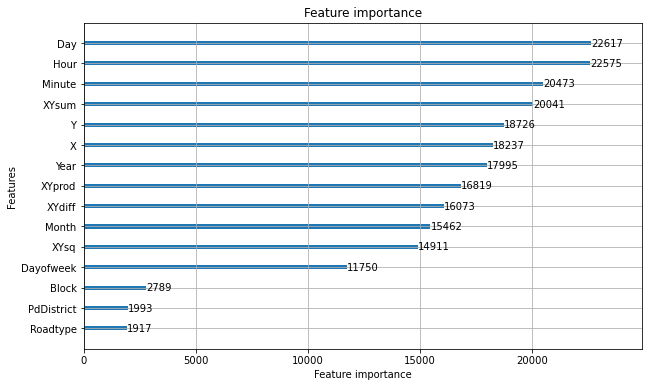

In [39]:
fig, ax = plt.subplots(figsize=(10,6))
lgb.plot_importance(lgb_rs, ax=ax)
plt.show()

## Native LightGBM 

### Remove low importance features

In [114]:
X_s, y_s = X.drop(columns=['PdDistrict', 'Roadtype', 'Block', 'Minute']), y

In [118]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size = 0.3)

In [140]:
trains = lgb.Dataset(X_train_s, label = y_train_s)
params = {
    'boosting':'gbdt',
    'objective':'multiclass',
    'num_class':39,
    'max_delta_step':0.9,
    'min_data_in_leaf': 100, #was 300
    'learning_rate': 0.2,
    'max_bin': 480,
    'feature_fraction':0.8,
    'num_leaves': 50,
    'bagging_fraction':0.8,
    'bagging_freq':10,
    'verbose' : 0
}
lgb_rs_s = lgb.train(params, trains, 140) # was 100

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [141]:
y_probs_train = lgb_rs_s.predict(X_train_s)
y_probs_val = lgb_rs_s.predict(X_test_s)

print(log_loss(y_train_s, y_probs_train))
print(log_loss(y_test_s, y_probs_val))

2.103331762014353
2.368949335955789


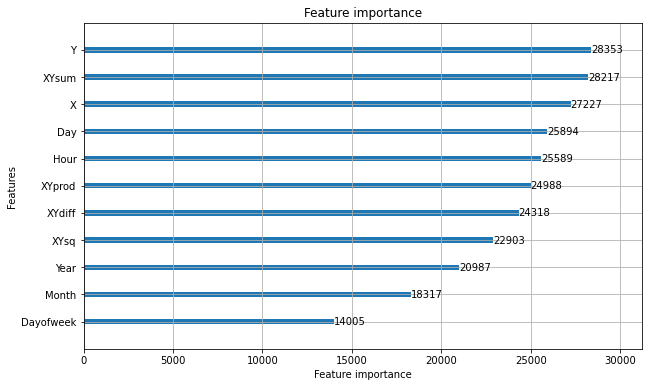

In [142]:
fig, ax = plt.subplots(figsize=(10,6))
lgb.plot_importance(lgb_rs_s, ax=ax)
plt.show()

### All features, native LGB

In [19]:
labelvec = train_df['Category']
LE = LabelEncoder()

encodedlabels = LE.fit_transform(labelvec) 

In [23]:
train_df_nolabel = train_df.drop('Category', axis=1)

In [31]:
trains = lg.Dataset(train_df_nolabel, label = encodedlabels, categorical_feature=['PdDistrict', 'Roadtype','Block'])
params = {
    'boosting':'gbdt',
    'objective':'multiclass',
    'num_class':39,
    'max_delta_step':0.9,
    'min_data_in_leaf': 20,
    'learning_rate': 0.4,
    'max_bin': 480,
    'num_leaves': 45,
    'verbose' : 0
}
bst = lg.train(params, trains, 120)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3047
[LightGBM] [Info] Number of data points in the train set: 877982, number of used features: 15
[LightGBM] [Info] Start training from score -6.363532
[LightGBM] [Info] Start training from score -2.435484
[LightGBM] [Info] Start training from score -7.679028
[LightGBM] [Info] Start training from score -8.018955
[LightGBM] [Info] Start training from score -3.173379
[LightGBM] [Info] Start training from score -5.314834
[LightGBM] [Info] Start training from score -5.958728
[LightGBM] [Info] Start training from score -2.789179
[LightGBM] [Info] Start training from score -5.323673
[LightGBM] [Info] Start training from score -6.624047
[LightGBM] [Info] Start training from score -8.140204
[LightGBM] [Info] Start training from score -7.48

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<Figure size 1080x720 with 0 Axes>

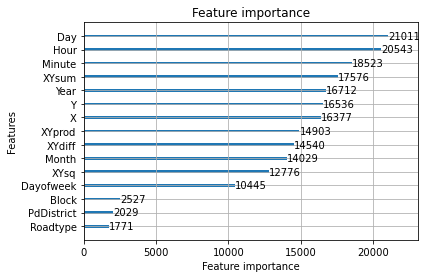

In [63]:
plt.figure(figsize=(15,10))
lg.plot_importance(bst);

### Try smaller bins, with native LightGBM to test speed

In [44]:
train_data = lg.Dataset(X_train, label = y_train)
validation_data = lg.Dataset(X_test, label = y_test, reference=train_data)

In [45]:
params = {
    'boosting':'gbdt',
    'objective':'multiclass',
    'num_class':39,
    'max_delta_step':0.9,
    'min_data_in_leaf': 20,
    'learning_rate': 0.4,
    'max_bin': 48,
    'num_leaves': 45,
    'verbose' : 1
}

In [46]:
bst_small = lg.train(params, train_data, 120,
                valid_sets=validation_data,
                early_stopping_rounds=5)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 425
[LightGBM] [Info] Number of data points in the train set: 614587, number of used features: 12
[LightGBM] [Info] Start training from score -6.357976
[LightGBM] [Info] Start training from score -2.432782
[LightGBM] [Info] Start training from score -7.634974
[LightGBM] [Info] Start training from score -8.010586
[LightGBM] [Info] Start training from score -3.176212
[LightGBM] [Info] Start training from score -5.297971
[LightGBM] [Info] Start training from score -5.966061
[LightGBM] [Info] Start training from score -2.788880
[LightGBM] [Info] Start training from score -5.327686
[LightGBM] [Info] Start training from score -6.619401
[LightGBM] [Info] Start training from score -8.141320
[LightGBM] [Info] Start training from score -7.520563
[LightGBM] [Info] Start training from score -4.416771
[Light

In [47]:
y_pred_val = bst_small.predict(X_test, num_iteration=bst.best_iteration)
y_pred_train = bst_small.predict(X_train, num_iteration=bst.best_iteration)

In [48]:
print(log_loss(y_test, y_pred_val))
print(log_loss(y_train, y_pred_train))

2.311797645138557
2.164921972536047


# Submit to  Kaggle

In [69]:
from zipfile import ZipFile

In [117]:
test_df = pd.read_csv('test.csv', parse_dates = ['Dates'], low_memory=False)
test_df.drop('Id', axis=1, inplace=True)

test_df_cat, test_df = preprocess_df(test_df, is_train=False)

In [130]:
test_df.drop(columns=['PdDistrict', 'Block', 'Roadtype'], inplace=True)

In [131]:
test_df_cat.drop(columns=['PdDistrict', 'Block', 'Roadtype', 'Minute'], inplace=True)

In [132]:
# y_probs_test = rfc.predict_proba(test_df_cat)
# y_probs_test = clf.predict_proba(test_df_cat)
y_probs_test = logreg_s.predict_proba(test_df_cat)

# y_probs_test = rfc_gs_best.predict_proba(test_df_cat)

In [133]:
submission_columns = df2['Category'].cat.categories

In [134]:
submission_csv = pd.DataFrame(y_probs_test, columns = submission_columns)

In [135]:
submission_csv.to_csv('submission.csv', index=True, index_label = 'Id')

In [72]:
with ZipFile('submission.zip', 'w') as zipObj:
    zipObj.write('submission.csv')

### Verify the format

In [108]:
sample_sub = pd.read_csv('sampleSubmission.csv', low_memory=False)

sample_sub.head()

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [128]:
# verify the format
sample_sub_mine = pd.read_csv('submission.csv', low_memory=False)

sample_sub_mine.head()

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0.006202,0.139089,0.000009,0.002154,0.029397,0.001752,0.004555,0.031074,0.007110,...,0.000064,0.008401,0.001588,0.049014,7.652322e-07,0.007094,0.059505,0.025866,0.038182,0.066168
1,1,0.002999,0.087832,0.000004,0.001332,0.001003,0.001614,0.016770,0.041762,0.007801,...,0.000058,0.007024,0.000388,0.029037,7.425107e-07,0.000821,0.050366,0.050242,0.044399,0.061446
2,2,0.003393,0.132351,0.000014,0.000957,0.027689,0.001579,0.003172,0.063280,0.008136,...,0.000045,0.008679,0.000582,0.045505,1.666010e-07,0.006635,0.055222,0.022119,0.052004,0.058501
3,3,0.003852,0.129892,0.000019,0.001322,0.035911,0.001369,0.003023,0.039866,0.007010,...,0.000069,0.008711,0.000706,0.047109,5.075563e-07,0.005811,0.067028,0.033115,0.040316,0.054055
4,4,0.003852,0.129892,0.000019,0.001322,0.035911,0.001369,0.003023,0.039866,0.007010,...,0.000069,0.008711,0.000706,0.047109,5.075563e-07,0.005811,0.067028,0.033115,0.040316,0.054055


In [ ]:
print(5)